In [1]:
#tabular data imports :
import pandas as pd
import numpy as np
import env
from env import username, password, host
from pydataset import data

# visualization imports:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector
# success metrics from earlier in the week: mean squared error and r^2 explained variance
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures

from scipy.stats import pearsonr, spearmanr
from scipy.stats import shapiro

import warnings
warnings.filterwarnings("ignore")
import explore as e
import wrangle as w
import os
directory = os.getcwd()

# Modeling

In [2]:
concrete = pd.read_csv('concrete.csv')
df = w.prepared_concrete_data(concrete)
train_scaled, validate_scaled, test_scaled = e.preprocess_concrete(df)


    train -> (618, 10)
    validate -> (206, 10)
    test -> (206, 10)


In [3]:
train_scaled.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,total_lbs_per_yd^3,strength
sample,,,,,,,,,,
600,0.399543,0.000000,0.000000,0.552716,0.000000,0.501050,0.657301,0.005495,0.3440,1647.63168
160,0.522831,0.000000,0.000000,0.560703,0.000000,0.531053,0.579528,0.074176,0.4640,4561.44510
854,0.650685,0.055648,0.469765,0.281150,0.360248,0.411041,0.629704,0.005495,0.9104,5042.97126
120,0.522831,0.000000,0.000000,0.560703,0.000000,0.531053,0.579528,0.016484,0.4640,2358.31788
979,0.737443,0.295771,0.000000,0.236422,0.577640,0.405041,0.526091,0.074176,0.8688,8963.34840


In [4]:
# Separate target column 'strength' from features
X_train = train_scaled.drop(columns='strength')
X_validate = validate_scaled.drop(columns='strength')
X_test = test_scaled.drop(columns='strength')
y_train= train_scaled[['strength']]
y_validate = validate_scaled[['strength']]
y_test = test_scaled[['strength']]

In [5]:
# simplyfing values for easier pluging into the functions
X = X_train
y = y_train

In [6]:
# run with the mean, which we saw was the better baseline previously
baseline = y.mean()
round(baseline,2)

strength    5103.33
dtype: float64

In [7]:
def evaluate_reg(y, yhat):
    '''
    based on two series, y_act, y_pred, (y, yhat), we
    evaluate and return the root mean squared error
    as well as the explained variance for the data.
    
    returns: rmse (float), rmse (float)
    '''
    rmse = mean_squared_error(y, yhat, squared=False)
    r2 = r2_score(y, yhat)
    return rmse, r2

In [8]:
# making a baseline guess dataframe
# that is the same shape as the y variable:
baseline_array = np.repeat(baseline, y.shape[0])

In [9]:
baseline_rmse, baseline_r2 = evaluate_reg(y, baseline_array)

In [10]:
# setting baseline for comparison with each model
eval_df = pd.DataFrame([{
    'Train Model': 'baseline',
    'rmse': round(baseline_rmse,2),
    'r²': round(baseline_r2,4)
}])
eval_df

,Train Model,rmse,r²
0,baseline,2373.7,0.0


In [11]:
# setting baseline for validation comparison
val_dict = pd.DataFrame([{
    'Val Model': 'baseline',
    'Val rmse': round(baseline_rmse,2),
    'Val r²': round(baseline_r2,4)
}])

val_dict

,Val Model,Val rmse,Val r²
0,baseline,2373.7,0.0


## Ordinary Least Squares (OLS)

# initial ML model
lr1 = LinearRegression()

# rfe has entered the chat:
rfe1 = RFE(lr1, n_features_to_select=1)

# fit
rfe1.fit(X, y)

# transform
X_train_rfe1 = rfe1.transform(X)

X_val_rfe1 = rfe1.transform(X_validate)

# feature that it selected?
rfe1.get_feature_names_out()

# lr1 as an object was created for our RFE process,
# lets just use that same object for our first model
lr1.fit(X_train_rfe1, y)

rmse, r_2 = evaluate_reg(y, lr1.predict(X_train_rfe1))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Train Model': 'ols_rfe_1',
        'rmse': rmse,
        'r²': r_2
    }
])], ignore_index=True, axis=0)
eval_df

# adding to val model list
val_rmse, val_r2 = evaluate_reg(y_validate, lr1.predict(X_val_rfe1))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val Model': 'ols_rfe_1',
    'Val rmse': val_rmse,
    'Val r²': val_r2
})])], ignore_index=True, axis=0)
val_dict

# initial ML model
lr1 = LinearRegression()

# rfe has entered the chat:
rfe2 = RFE(lr1, n_features_to_select=2)

# fit
rfe2.fit(X, y)

# transform
X_train_rfe2 = rfe2.transform(X)

X_val_rfe2 = rfe2.transform(X_validate)

# feature that it selected?
rfe2.get_feature_names_out()

# lr1 as an object was created for our RFE process,
# lets just use that same object for our first model
lr1.fit(X_train_rfe2, y)

rmse, r_2 = evaluate_reg(y, lr1.predict(X_train_rfe2))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Train Model': 'ols_rfe_2',
        'rmse': rmse,
        'r²': r_2
    }
])], ignore_index=True, axis=0)
eval_df

# adding to val model list
val_rmse, val_r2 = evaluate_reg(y_validate, lr1.predict(X_val_rfe2))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val Model': 'ols_rfe_2',
    'Val rmse': val_rmse,
    'Val r²': val_r2
})])], ignore_index=True, axis=0)
val_dict

In [12]:
# initial ML model
lr1 = LinearRegression()

# rfe has entered the chat:
rfe3 = RFE(lr1, n_features_to_select=3)

# fit
rfe3.fit(X, y)

# transform
X_train_rfe3 = rfe3.transform(X)

X_val_rfe3 = rfe3.transform(X_validate)

X_test_rfe3 = rfe3.transform(X_test)

In [13]:
# feature that it selected?
rfe3.get_feature_names_out()

array(['coarseagg', 'fineagg', 'total_lbs_per_yd^3'], dtype=object)

In [14]:
# lr1 as an object was created for our RFE process,
# lets just use that same object for our first model
lr1.fit(X_train_rfe3, y)

LinearRegression()

In [15]:
rmse, r_2 = evaluate_reg(y, lr1.predict(X_train_rfe3))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Train Model': 'ols_rfe_3',
        'rmse': rmse,
        'r²': r_2
    }
])], ignore_index=True, axis=0)
eval_df

,Train Model,rmse,r²
0,baseline,2373.700000,0.000000
1,ols_rfe_3,1891.601542,0.364951


In [16]:
# adding to val model list
val_rmse, val_r2 = evaluate_reg(y_validate, lr1.predict(X_val_rfe3))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val Model': 'ols_rfe_3',
    'Val rmse': val_rmse,
    'Val r²': val_r2
})])], ignore_index=True, axis=0)
val_dict

,Val Model,Val rmse,Val r²
0,baseline,2373.700000,0.000000
1,ols_rfe_3,1757.380057,0.505661


## Generalized Linear Model (GLM)

# make the thing
gams25 = TweedieRegressor(power=0.25)
# fit the dang ol thing
gams25.fit(X, y)
# using it below

# using it
rmse, r_2 = evaluate_reg(y, gams25.predict(X))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Train Model': 'gamma_ols_0.25',
        'rmse': rmse,
        'r²': r_2
    }
])], ignore_index=True, axis=0)
eval_df

val_rmse, val_r2 = evaluate_reg(y_validate, gams25.predict(X_validate))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val Model': 'gamma_ols_0.25',
    'Val rmse': val_rmse,
    'Val r²': val_r2
})])], ignore_index=True, axis=0)
val_dict

In [17]:
# Step 1: Select desired features for training
selected_features = ['coarseagg', 'fineagg', 'total_lbs_per_yd^3']
X_train_selected = X_train[selected_features]
# Step 2: Fit the TweedieRegressor model to the selected features
gams25 = TweedieRegressor(power=0.25)
gams25.fit(X_train_selected, y_train)

TweedieRegressor(power=0.25)

In [18]:
# Selecting the same features from the validation and test sets
X_validate_selected = X_validate[selected_features]
X_test_selected = X_test[selected_features]

# Use the trained model to predict and evaluate on the validation and test sets
y_val_pred = gams25.predict(X_validate_selected)
y_test_pred = gams25.predict(X_test_selected)

In [19]:
# using it
rmse, r_2 = evaluate_reg(y_train, gams25.predict(X_train_selected))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Train Model': 'gamma_ols_0.25.3',
        'rmse': rmse,
        'r²': r_2
    }
])], ignore_index=True, axis=0)
eval_df

,Train Model,rmse,r²
0,baseline,2373.700000,0.000000
1,ols_rfe_3,1891.601542,0.364951
2,gamma_ols_0.25.3,1923.083519,0.343637


In [20]:
val_rmse, val_r2 = evaluate_reg(y_validate, gams25.predict(X_validate_selected))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val Model': 'gamma_ols_0.25.3',
    'Val rmse': val_rmse,
    'Val r²': val_r2
})])], ignore_index=True, axis=0)
val_dict

,Val Model,Val rmse,Val r²
0,baseline,2373.700000,0.000000
1,ols_rfe_3,1757.380057,0.505661
2,gamma_ols_0.25.3,1779.309776,0.493246


## Polynomial Regression

# Step 1: Select desired features
selected_features = ['cement', 'total_lbs_per_yd^3', 'water']
X_train_selected = X_train[selected_features]
X_validate_selected = X_validate[selected_features]
X_test_selected = X_test[selected_features]

# Step 2: Apply polynomial transformation
pf2 = PolynomialFeatures(degree=2)

# Fit on training set and transform the selected features
x_train_sq_selected = pf2.fit_transform(X_train_selected)

# Transform the selected features for validation and test sets
x_val_sq_selected = pf2.transform(X_validate_selected)
x_test_sq_selected = pf2.transform(X_test_selected)

# Step 3: Fit the model to the transformed features
plyreg2 = LinearRegression()
plyreg2.fit(x_train_sq_selected, y_train)

# Now you can use plyreg2 to make predictions and evaluate the model
# For instance, to evaluate on the validation set:
y_val_pred = plyreg2.predict(x_val_sq_selected)

# concating on val_dict to add another model on train
rmse, r_2 = evaluate_reg(y_train, plyreg2.predict(x_train_sq_selected))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Train Model': 'quad_reg2.3.1',
        'rmse': rmse,
        'r²': r_2
    }
])], ignore_index=True, axis=0)
eval_df

# concating on val_dict to add another model on validate
val_rmse, val_r2 = evaluate_reg(y_validate, plyreg2.predict(x_val_sq_selected))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val Model': 'quad_reg2.3.1',
    'Val rmse': val_rmse,
    'Val r²': val_r2
})])], ignore_index=True, axis=0)
val_dict

In [21]:
# Step 1: Select desired features
selected_features = ['coarseagg', 'fineagg', 'total_lbs_per_yd^3']
X_train_selected = X_train[selected_features]
X_validate_selected = X_validate[selected_features]
X_test_selected = X_test[selected_features]

In [22]:
# Step 2: Apply polynomial transformation
pf2 = PolynomialFeatures(degree=2)

# Fit on training set and transform the selected features
x_train_sq_selected = pf2.fit_transform(X_train_selected)

# Transform the selected features for validation and test sets
x_val_sq_selected = pf2.transform(X_validate_selected)
x_test_sq_selected = pf2.transform(X_test_selected)

In [23]:
# Step 3: Fit the model to the transformed features
plyreg2 = LinearRegression()
plyreg2.fit(x_train_sq_selected, y_train)

# Now you can use plyreg2 to make predictions and evaluate the model
# For instance, to evaluate on the validation set:
y_val_pred = plyreg2.predict(x_val_sq_selected)

In [24]:
# concating on val_dict to add another model on train
rmse, r_2 = evaluate_reg(y_train, plyreg2.predict(x_train_sq_selected))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Train Model': 'quad_reg2.3.2',
        'rmse': rmse,
        'r²': r_2
    }
])], ignore_index=True, axis=0)
eval_df

,Train Model,rmse,r²
0,baseline,2373.700000,0.000000
1,ols_rfe_3,1891.601542,0.364951
2,gamma_ols_0.25.3,1923.083519,0.343637
3,quad_reg2.3.2,1840.737195,0.398645


In [25]:
# concating on val_dict to add another model on validate
val_rmse, val_r2 = evaluate_reg(y_validate, plyreg2.predict(x_val_sq_selected))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val Model': 'quad_reg2.3.2',
    'Val rmse': val_rmse,
    'Val r²': val_r2
})])], ignore_index=True, axis=0)
val_dict

,Val Model,Val rmse,Val r²
0,baseline,2373.700000,0.000000
1,ols_rfe_3,1757.380057,0.505661
2,gamma_ols_0.25.3,1779.309776,0.493246
3,quad_reg2.3.2,1817.096007,0.471494


In [26]:
# Step 1: Select desired features
selected_features = ['coarseagg', 'fineagg', 'total_lbs_per_yd^3']
X_train_selected = X_train[selected_features]
X_validate_selected = X_validate[selected_features]
X_test_selected = X_test[selected_features]

In [27]:
# Step 2: Apply polynomial transformation
pf3 = PolynomialFeatures(degree=3)

# Fit on training set and transform the selected features
x_train_sq_selected = pf3.fit_transform(X_train_selected)

# Transform the selected features for validation and test sets
x_val_sq_selected = pf3.transform(X_validate_selected)
x_test_sq_selected = pf3.transform(X_test_selected)

In [28]:
# Step 3: Fit the model to the transformed features
plyreg3 = LinearRegression()
plyreg3.fit(x_train_sq_selected, y_train)

# Now you can use plyreg3 to make predictions and evaluate the model
# For instance, to evaluate on the validation set:
y_val_pred = plyreg3.predict(x_val_sq_selected)

In [29]:
# concating on val_dict to add another model on train
rmse, r_2 = evaluate_reg(y_train, plyreg3.predict(x_train_sq_selected))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Train Model': 'quad_reg3.3',
        'rmse': rmse,
        'r²': r_2
    }
])], ignore_index=True, axis=0)
eval_df

,Train Model,rmse,r²
0,baseline,2373.700000,0.000000
1,ols_rfe_3,1891.601542,0.364951
2,gamma_ols_0.25.3,1923.083519,0.343637
3,quad_reg2.3.2,1840.737195,0.398645
4,quad_reg3.3,1778.313463,0.438740


In [30]:
# concating on val_dict to add another model on validate
val_rmse, val_r2 = evaluate_reg(y_validate, plyreg3.predict(x_val_sq_selected))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val Model': 'quad_reg3.3',
    'Val rmse': val_rmse,
    'Val r²': val_r2
})])], ignore_index=True, axis=0)
val_dict

,Val Model,Val rmse,Val r²
0,baseline,2373.700000,0.000000
1,ols_rfe_3,1757.380057,0.505661
2,gamma_ols_0.25.3,1779.309776,0.493246
3,quad_reg2.3.2,1817.096007,0.471494
4,quad_reg3.3,1826.639054,0.465929


# Step 1: Select desired features
selected_features = ['coarseagg', 'fineagg', 'total_lbs_per_yd^3']
X_train_selected = X_train[selected_features]
X_validate_selected = X_validate[selected_features]
X_test_selected = X_test[selected_features]

# Step 2: Apply polynomial transformation
pf4 = PolynomialFeatures(degree=4)

# Fit on training set and transform the selected features
x_train_sq_selected = pf4.fit_transform(X_train_selected)

# Transform the selected features for validation and test sets
x_val_sq_selected = pf4.transform(X_validate_selected)
x_test_sq_selected = pf4.transform(X_test_selected)

# Step 3: Fit the model to the transformed features
plyreg4 = LinearRegression()
plyreg4.fit(x_train_sq_selected, y_train)

# Now you can use plyreg3 to make predictions and evaluate the model
# For instance, to evaluate on the validation set:
y_val_pred = plyreg4.predict(x_val_sq_selected)

# concating on val_dict to add another model on train
rmse, r_2 = evaluate_reg(y_train, plyreg4.predict(x_train_sq_selected))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Train Model': 'quad_reg4.3',
        'rmse': rmse,
        'r²': r_2
    }
])], ignore_index=True, axis=0)
eval_df

# concating on val_dict to add another model on validate
val_rmse, val_r2 = evaluate_reg(y_validate, plyreg4.predict(x_val_sq_selected))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val Model': 'quad_reg4.3',
    'Val rmse': val_rmse,
    'Val r²': val_r2
})])], ignore_index=True, axis=0)
val_dict

# Step 1: Select desired features
selected_features = ['cement', 'total_lbs_per_yd^3','superplastic']
X_train_selected = X_train[selected_features]
X_validate_selected = X_validate[selected_features]
X_test_selected = X_test[selected_features]

# Step 2: Apply polynomial transformation
pf2 = PolynomialFeatures(degree=2)

# Fit on training set and transform the selected features
x_train_sq_selected = pf2.fit_transform(X_train_selected)

# Transform the selected features for validation and test sets
x_val_sq_selected = pf2.transform(X_validate_selected)
x_test_sq_selected = pf2.transform(X_test_selected)

# Step 3: Fit the model to the transformed features
plyreg2 = LinearRegression()
plyreg2.fit(x_train_sq_selected, y_train)

# Now you can use plyreg2 to make predictions and evaluate the model
# For instance, to evaluate on the validation set:
y_val_pred = plyreg2.predict(x_val_sq_selected)

# concating on val_dict to add another model on train
rmse, r_2 = evaluate_reg(y_train, plyreg2.predict(x_train_sq_selected))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Train Model': 'quad_reg2.3.3',
        'rmse': rmse,
        'r²': r_2
    }
])], ignore_index=True, axis=0)
eval_df

# concating on val_dict to add another model on validate
val_rmse, val_r2 = evaluate_reg(y_validate, plyreg2.predict(x_val_sq_selected))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val Model': 'quad_reg2.3.3',
    'Val rmse': val_rmse,
    'Val r²': val_r2
})])], ignore_index=True, axis=0)
val_dict

# Step 1: Select desired features
selected_features = ['total_lbs_per_yd^3']
X_train_selected = X_train[selected_features]
X_validate_selected = X_validate[selected_features]
X_test_selected = X_test[selected_features]

# Step 2: Apply polynomial transformation
pf2 = PolynomialFeatures(degree=2)

# Fit on training set and transform the selected features
x_train_sq_selected = pf2.fit_transform(X_train_selected)

# Transform the selected features for validation and test sets
x_val_sq_selected = pf2.transform(X_validate_selected)
x_test_sq_selected = pf2.transform(X_test_selected)

# Step 3: Fit the model to the transformed features
plyreg2 = LinearRegression()
plyreg2.fit(x_train_sq_selected, y_train)

# Now you can use plyreg2 to make predictions and evaluate the model
# For instance, to evaluate on the validation set:
y_val_pred = plyreg2.predict(x_val_sq_selected)

# concating on val_dict to add another model on train
rmse, r_2 = evaluate_reg(y_train, plyreg2.predict(x_train_sq_selected))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Train Model': 'quad_reg2.1.1',
        'rmse': rmse,
        'r²': r_2
    }
])], ignore_index=True, axis=0)
eval_df

# concating on val_dict to add another model on validate
val_rmse, val_r2 = evaluate_reg(y_validate, plyreg2.predict(x_val_sq_selected))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val Model': 'quad_reg2.1.1',
    'Val rmse': val_rmse,
    'Val r²': val_r2
})])], ignore_index=True, axis=0)
val_dict

# Step 1: Select desired features
selected_features = ['fineagg', 'total_lbs_per_yd^3']
X_train_selected = X_train[selected_features]
X_validate_selected = X_validate[selected_features]
X_test_selected = X_test[selected_features]

# Step 2: Apply polynomial transformation
pf2 = PolynomialFeatures(degree=2)

# Fit on training set and transform the selected features
x_train_sq_selected = pf2.fit_transform(X_train_selected)

# Transform the selected features for validation and test sets
x_val_sq_selected = pf2.transform(X_validate_selected)
x_test_sq_selected = pf2.transform(X_test_selected)

# Step 3: Fit the model to the transformed features
plyreg2 = LinearRegression()
plyreg2.fit(x_train_sq_selected, y_train)

# Now you can use plyreg2 to make predictions and evaluate the model
# For instance, to evaluate on the validation set:
y_val_pred = plyreg2.predict(x_val_sq_selected)

# concating on val_dict to add another model on train
rmse, r_2 = evaluate_reg(y_train, plyreg2.predict(x_train_sq_selected))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Train Model': 'quad_reg2.2.2',
        'rmse': rmse,
        'r²': r_2
    }
])], ignore_index=True, axis=0)
eval_df

# concating on val_dict to add another model on validate
val_rmse, val_r2 = evaluate_reg(y_validate, plyreg2.predict(x_val_sq_selected))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val Model': 'quad_reg2.2.2',
    'Val rmse': val_rmse,
    'Val r²': val_r2
})])], ignore_index=True, axis=0)
val_dict

## LassoLars

# make it
lasso = LassoLars(alpha=1)
# fit it:
lasso = lasso.fit(X, y)

rmse, r_2 = evaluate_reg(y, lasso.predict(X))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Train Model': 'lasso',
        'rmse': rmse,
        'r²': r_2
    }
])], ignore_index=True, axis=0)
eval_df

# concating on val_dict to add another model on validate
val_rmse, val_r2 = evaluate_reg(y_validate, lasso.predict(X_validate))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val Model': 'lasso',
    'Val rmse': val_rmse,
    'Val r²': val_r2
})])], ignore_index=True, axis=0)
val_dict

In [31]:
# Step 1: Select desired features
selected_features = ['coarseagg', 'fineagg', 'total_lbs_per_yd^3']
X_train_selected = X_train[selected_features]

# Step 2: Fit the LassoLars model to the selected features
lasso = LassoLars(alpha=1)
lasso.fit(X_train_selected, y_train)

LassoLars(alpha=1)

In [32]:
# Selecting the same features from the validation and test sets
X_validate_selected = X_validate[selected_features]
X_test_selected = X_test[selected_features]

# Now you can use the trained model to predict and evaluate on the validation and test sets
y_val_pred = lasso.predict(X_validate_selected)
y_test_pred = lasso.predict(X_test_selected)

In [33]:
rmse, r_2 = evaluate_reg(y_train, lasso.predict(X_train_selected))
eval_df = pd.concat([eval_df, pd.DataFrame(
[
    {
        'Train Model': 'lasso.3',
        'rmse': rmse,
        'r²': r_2
    }
])], ignore_index=True, axis=0)
eval_df

,Train Model,rmse,r²
0,baseline,2373.700000,0.000000
1,ols_rfe_3,1891.601542,0.364951
2,gamma_ols_0.25.3,1923.083519,0.343637
3,quad_reg2.3.2,1840.737195,0.398645
4,quad_reg3.3,1778.313463,0.438740
5,lasso.3,1891.634055,0.364930


In [34]:
# concating on val_dict to add another model on validate
val_rmse, val_r2 = evaluate_reg(y_validate, lasso.predict(X_validate_selected))
val_dict = pd.concat([val_dict, pd.DataFrame([({
    'Val Model': 'lasso.3',
    'Val rmse': val_rmse,
    'Val r²': val_r2
})])], ignore_index=True, axis=0)
val_dict

,Val Model,Val rmse,Val r²
0,baseline,2373.700000,0.000000
1,ols_rfe_3,1757.380057,0.505661
2,gamma_ols_0.25.3,1779.309776,0.493246
3,quad_reg2.3.2,1817.096007,0.471494
4,quad_reg3.3,1826.639054,0.465929
5,lasso.3,1759.978848,0.504197


(0.0, 12000.0)

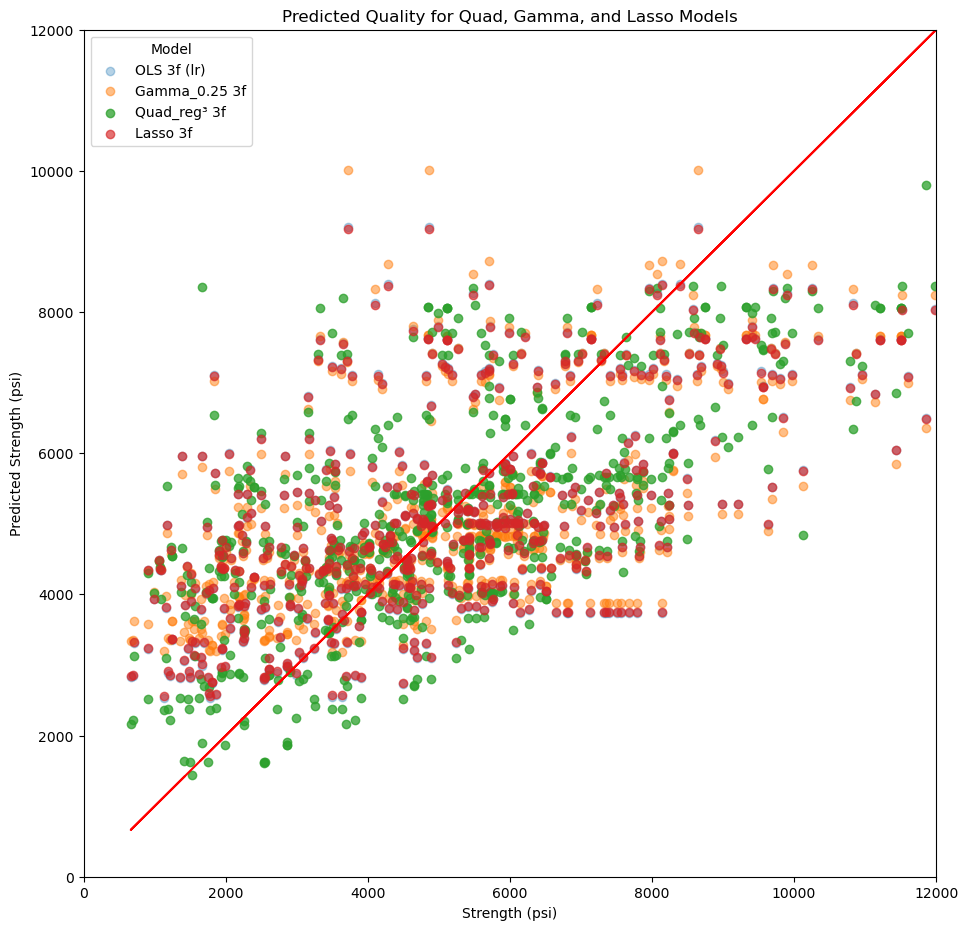

In [35]:
plt.figure(figsize=(11, 11))
plt.scatter(y, lr1.predict(X_train_rfe3), label='OLS 3f (lr)', alpha=0.33)
plt.scatter(y_train, gams25.predict(X_train_selected), label= 'Gamma_0.25 3f', alpha=0.5)
plt.scatter(y_train, plyreg3.predict(x_train_sq_selected), label='Quad_reg³ 3f', alpha=0.75)
plt.scatter(y_train, lasso.predict(X_train_selected), label= 'Lasso 3f', alpha=0.66)
plt.title('Predicted Quality for Quad, Gamma, and Lasso Models')
plt.plot(y,y, ls='-', c='r')
plt.ylabel('Predicted Strength (psi)')
plt.xlabel('Strength (psi)')
plt.legend(title='Model')
# Set the axis limits
plt.xlim(left=0, right=12000) 
plt.ylim(bottom=0, top=12000)

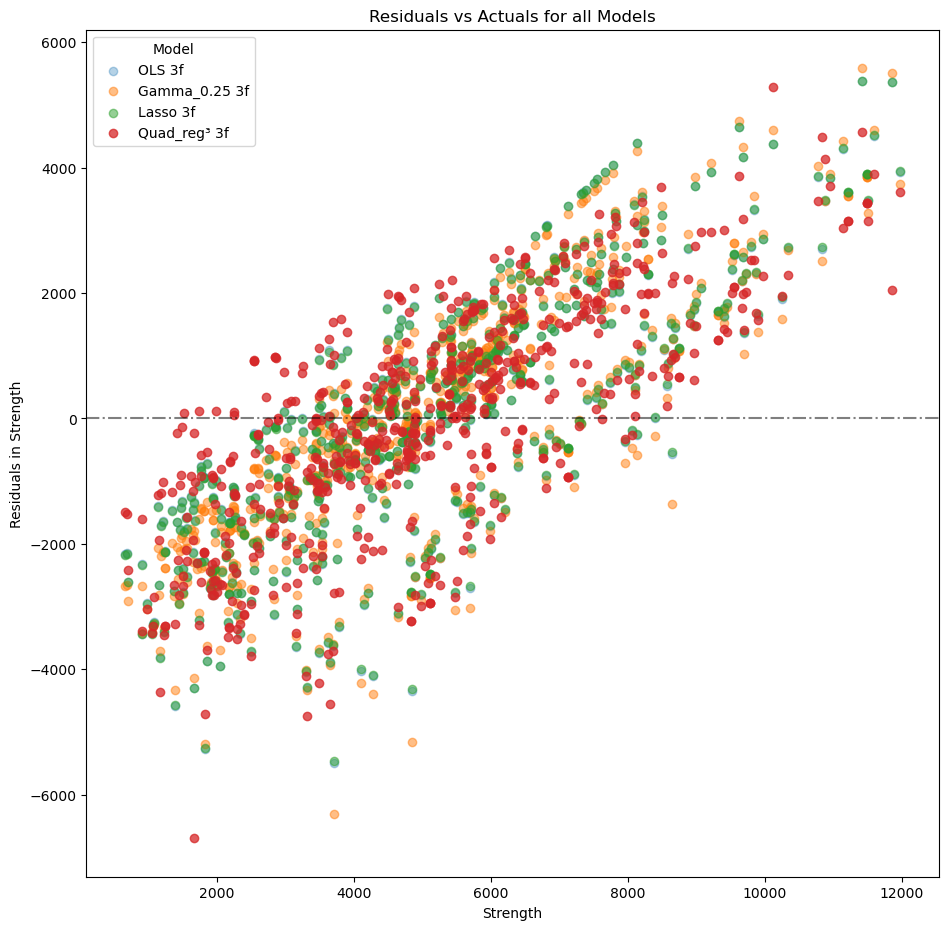

In [36]:
# Convert y to a numpy array for consistent operations
y_array = y.values.ravel()  # This flattens y to a 1D numpy array

# Now plotting
plt.figure(figsize=(11, 11))
plt.scatter(y, y - lr1.predict(X_train_rfe3), label='OLS 3f', alpha=0.33)
plt.scatter(y_train, y_array - gams25.predict(X_train_selected), label='Gamma_0.25 3f', alpha=0.5)
plt.scatter(y_train, y_array - lasso.predict(X_train_selected), label='Lasso 3f', alpha=0.5)
plt.scatter(y_train, y - plyreg3.predict(x_train_sq_selected), label='Quad_reg³ 3f', alpha=0.75)
plt.title('Residuals vs Actuals for all Models')
plt.axhline(0, ls='-.', c='k', alpha=0.5)
plt.ylabel('Residuals in Strength')
plt.xlabel('Strength')
plt.legend(title='Model')
plt.show()


### Test Model: Ploynomial Regression to the power of 3

In [37]:
# setting baseline for validation comparison
test_dict = pd.DataFrame([{
    'Test Model': 'baseline',
    'Test rmse': round(baseline_rmse,2),
    'Test r²': round(baseline_r2,4)
}])
# concating on val_dict to add another model on validate
test_rmse, test_r2 = evaluate_reg(y_test, plyreg3.predict(x_test_sq_selected))
test_dict = pd.concat([test_dict, pd.DataFrame([({
    'Test Model': 'quad_reg3.3',
    'Test rmse': test_rmse,
    'Test r²': test_r2
})])], ignore_index=True, axis=0)

test_dict

,Test Model,Test rmse,Test r²
0,baseline,2373.700000,0.000000
1,quad_reg3.3,1784.105793,0.479165
